In [1]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json


# Point this path to where you unzipped the clinical_trial_risk repository
REPO_DIR = "/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/projects_client/clinical_trial_risk"
sys.path.append(REPO_DIR + "/front_end")

df_annotations = pd.read_csv("../../data/ctgov/annotations/all_annotations.csv")


In [2]:
MODELS_DIR = REPO_DIR + '/front_end/models/'

In [3]:
from util.page_tokeniser import tokenise_pages

In [4]:
from processors.sap_extractor_spacy import SapExtractorSpacy

2022-11-19 23:11:12.920214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-19 23:11:13.061795: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-19 23:11:13.061812: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-19 23:11:13.089641: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-19 23:11:13.669959: W tensorflow/stream_executor/platform/de

In [5]:
from processors.num_arms_extractor import NumArmsExtractor

In [6]:
from processors.num_arms_extractor_spacy import NumArmsExtractorSpacy

In [7]:
from processors.num_arms_extractor_naive_bayes import NumArmsExtractorNaiveBayes

In [8]:
arms_extractor_rule_based = NumArmsExtractor()

In [9]:
arms_extractor_nb = NumArmsExtractorNaiveBayes(MODELS_DIR + "arms_classifier_document_level.pkl.bz2")

Initialising Num Arms classifier /media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/projects_client/clinical_trial_risk/front_end/models/arms_classifier_document_level.pkl.bz2


/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:32

In [10]:
arms_extractor_spacy = NumArmsExtractorSpacy(MODELS_DIR + "spacy-textcat-arms-21-model-best")

/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/py310/lib/python3.10/site-packages/spacy/util.py:865: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.4.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [11]:
def get_num_arms_clean(num):
    if pd.isna(num):
        return None
    if num >= 3:
        return "3+"
    return str(int(num))
df_annotations["num_arms_clean"] = df_annotations["num_arms"].apply(get_num_arms_clean)

In [12]:
df_train = df_annotations[df_annotations.train_val == "val"]

In [13]:
df_train_small = df_train[~df_train.num_arms_clean.isna()].sample(100)

In [14]:
texts =[]
for i in range(len(df_train_small)):
    file_name = df_train_small.file.iloc[i]

    with open("/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/data_open/read_ctgov_data/json/" + file_name + ".json", "r", encoding="utf-8") as f:
        pages = json.load(f)
    texts.append(pages)
df_train_small["pages"] = texts

In [15]:
pred1 = []
pred2 = []
pred3 = []

y1 = []
y2 = []
y3 = []
for idx in range(len(df_train_small)):
    tokenised_pages = tokenise_pages(df_train_small.pages.iloc[idx])
    
    sap_to_pages = arms_extractor_rule_based.process(tokenised_pages)
    pred1.append(sap_to_pages["prediction"])
    y1.append(int(sap_to_pages["prediction"] is not None))
    
    sap_to_pages_nb = arms_extractor_nb.process(tokenised_pages)
    pred2.append(sap_to_pages_nb["prediction"])
    y2.append(sap_to_pages_nb["proba"])
    
    sap_to_pages_spacy = arms_extractor_spacy.process(tokenised_pages)
    pred3.append(sap_to_pages_spacy["prediction"])
    y3.append(sap_to_pages_spacy["probas"])


In [16]:
df_train_small["y1"] = y1
df_train_small["y2"] = y2
df_train_small["y3"] = y3


In [17]:
df_train_small["y1_pred"] = pred1
df_train_small["y2_pred"] = pred2
df_train_small["y3_pred"] = pred3


In [27]:
accuracy_score(df_train_small.y1_pred.apply(lambda x : str(int(x)) if not pd.isna(x) else "None"), df_train_small.num_arms_clean.apply(str))

0.05

In [28]:
accuracy_score(df_train_small.y2_pred.apply(str), df_train_small.num_arms_clean.apply(str))

0.52

In [29]:
accuracy_score(df_train_small.y3_pred.apply(str), df_train_small.num_arms_clean.apply(str))

0.63

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

In [31]:
ConfusionMatrixDisplay.from_predictions(df_train_small.num_arms_clean, df_train_small.y1_pred)
plt.xticks(rotation=90)
;

ValueError: Input contains NaN.

''

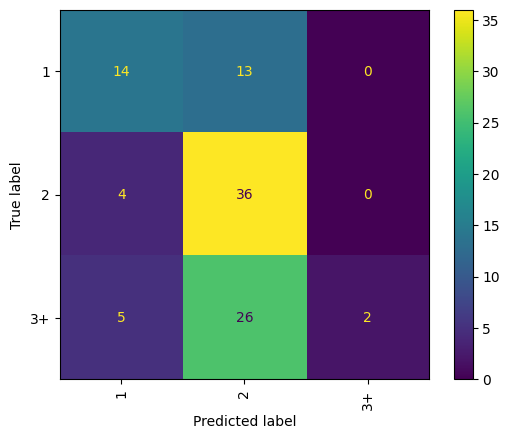

In [32]:
ConfusionMatrixDisplay.from_predictions(df_train_small.num_arms_clean, df_train_small.y2_pred)
plt.xticks(rotation=90)
;

''

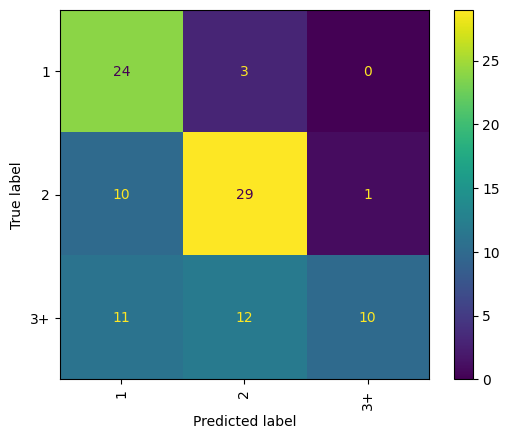

In [33]:
ConfusionMatrixDisplay.from_predictions(df_train_small.num_arms_clean, df_train_small.y3_pred)
plt.xticks(rotation=90)
;

In [34]:
import matplotlib.pyplot as plt

In [35]:
df_train_small.num_arms_clean.value_counts()

2     40
3+    33
1     27
Name: num_arms_clean, dtype: int64

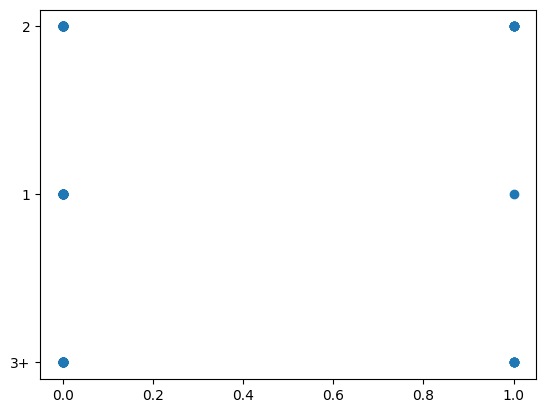

In [36]:
plt.scatter(df_train_small.y1, df_train_small.num_arms_clean)

TypeError: unhashable type: 'dict'

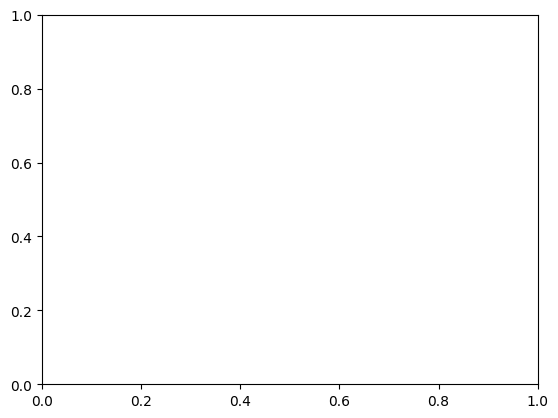

In [37]:
plt.scatter(df_train_small.y2, df_train_small.num_arms_clean)

In [54]:
probas4 = []
for idx in range(len(df_train_small)):
    m = {}
    for num_arms in ["1", "2", "3+"]:
        m[num_arms] = df_train_small["y2"].iloc[idx][num_arms] /2 + df_train_small["y3"].iloc[idx][num_arms]/2
    probas4.append(m)
df_train_small["y4"] = probas4

In [55]:
from sklearn.metrics import roc_auc_score
for model in 2, 3, 4:
    all_aucs = []
    for num_arms in ["1", "2", "3+"]:
        roc_auc = roc_auc_score(df_train_small.num_arms_clean == num_arms, df_train_small[f"y{model}"].apply(lambda m : m[num_arms]))
        print (f"SAP ROC AUC {roc_auc} for model {model} arms {num_arms}")
        all_aucs.append(roc_auc)
    print (f"Average model {model}", np.mean(all_aucs))

SAP ROC AUC 0.8295281582952816 for model 2 arms 1
SAP ROC AUC 0.7554166666666666 for model 2 arms 2
SAP ROC AUC 0.7327001356852103 for model 2 arms 3+
Average model 2 0.7725483202157196
SAP ROC AUC 0.8579401319127347 for model 3 arms 1
SAP ROC AUC 0.7827083333333333 for model 3 arms 2
SAP ROC AUC 0.689280868385346 for model 3 arms 3+
Average model 3 0.7766431112104714
SAP ROC AUC 0.8741755454084221 for model 4 arms 1
SAP ROC AUC 0.7789583333333333 for model 4 arms 2
SAP ROC AUC 0.7727272727272727 for model 4 arms 3+
Average model 4 0.8086203838230093


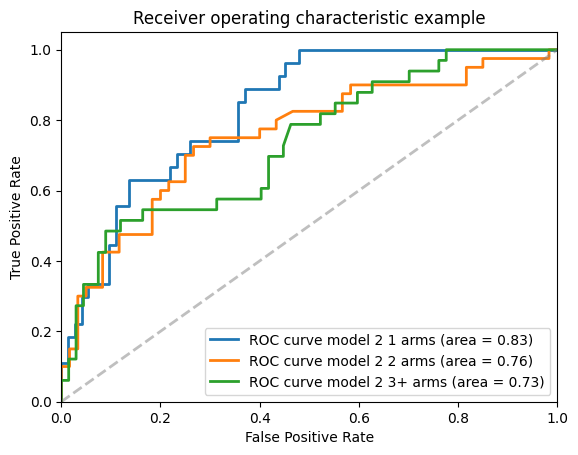

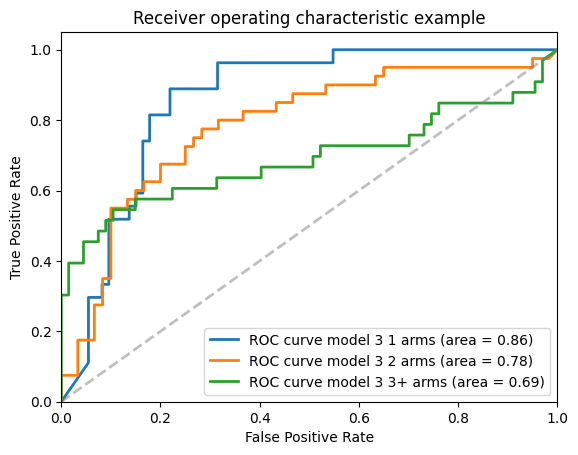

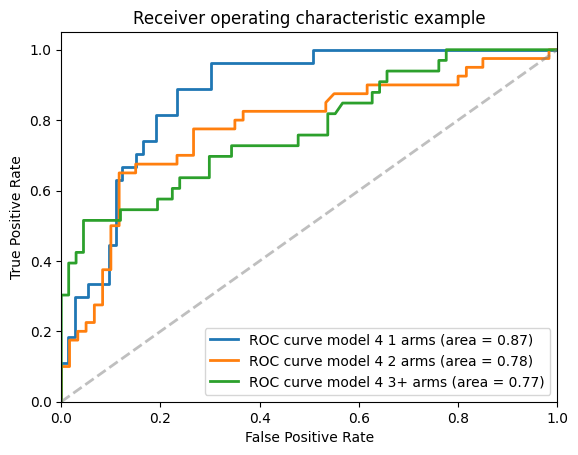

In [56]:
plt.figure()
lw = 2
    
for model in 2, 3, 4:
    for num_arms in ["1", "2", "3+"]:
        fpr, tpr, _ = roc_curve(df_train_small.num_arms_clean==num_arms,df_train_small[f"y{model}"].apply(lambda m : m[num_arms]))
        roc_auc = auc(fpr, tpr)
        plt.plot(
            fpr,
            tpr,
            # color="darkorange",
            lw=lw,
            label=f"ROC curve model {model} {num_arms} arms (area = {roc_auc:0.2f})"
        )
    plt.plot([0, 1], [0, 1], color="gray", alpha=0.5, lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()